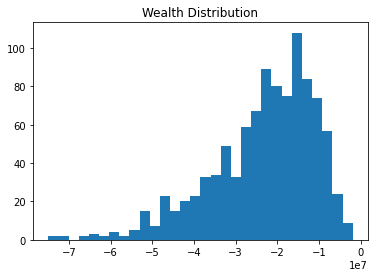

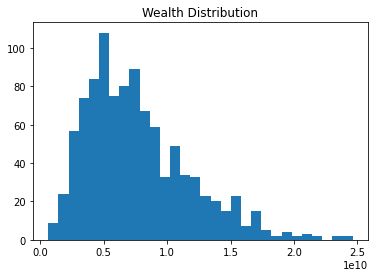

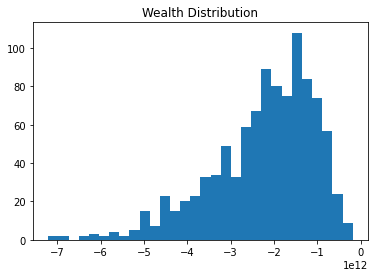

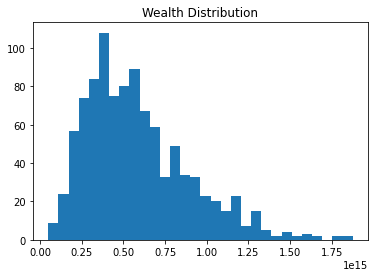

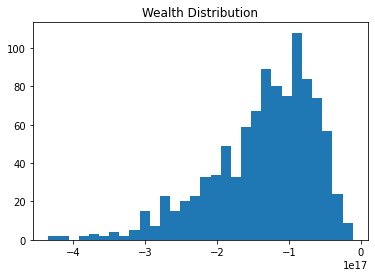

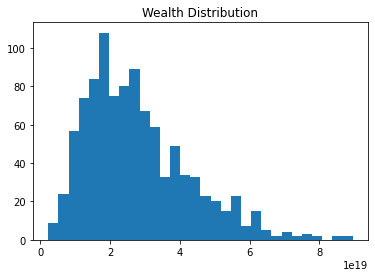

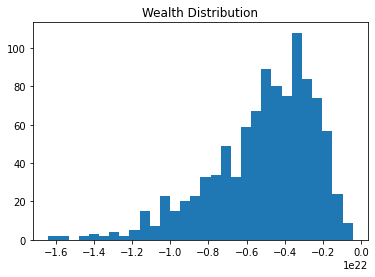

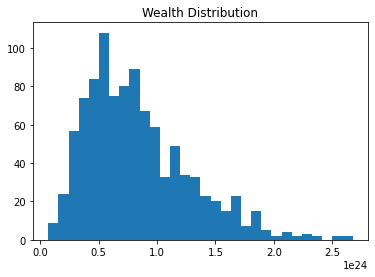

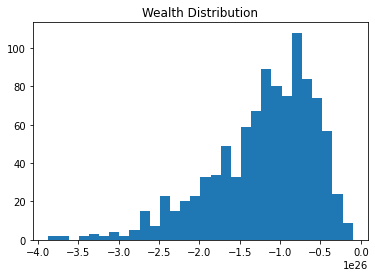

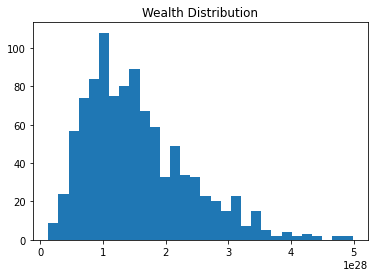

In [23]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import numpy as np
import scipy.stats as stats
import random
from numpy.random import choice
from numpy import exp
import matplotlib.pyplot as plt

# PARAMETERS
num_people = 1000
median_income = 50000
gr = [10,20]
periods = 10
bad_energy_price = 10
good_energy_price = 5
bad_energy_price_growth_rate = 0.05
good_energy_price_growth_rate = 0.05

# HELPER FUNCTIONS 
class GiniCalculationError(Exception):
    pass

def calculate_gini(incomes):
    incomes = np.sort(incomes)
    n = len(incomes)
    index = np.arange(1, n + 1)
    return ((np.sum((2 * index - n  - 1) * incomes)) / (n * np.sum(incomes)))

def generate_income_distribution(num_people, median_income, gini_target):
    alpha = (gini_target + 1) / (2 - gini_target)
    for _ in range(10000):
        incomes = stats.gamma.rvs(alpha, scale=median_income/alpha, size=num_people)
        gini_current = calculate_gini(incomes)
        if np.isclose(gini_current, gini_target, atol=0.01):
            return incomes
        elif gini_current < gini_target:
            alpha *= 0.9
        else:
            alpha *= 1.1

    error_message = f"Failed to reach target Gini coefficient in 1000 iterations. Current Gini: {gini_current}"
    raise GiniCalculationError(error_message)

def calculate_wealth_distribution(incomes, num_bins=10):
    total_wealth = np.sum(incomes)
    hist, bin_edges = np.histogram(incomes, bins=num_bins)
    bin_wealths = [(bin_edges[i+1] - bin_edges[i]) * hist[i] for i in range(num_bins)]
    wealth_distribution = bin_wealths / total_wealth
    return wealth_distribution

# AGENT
class Person(Agent):
    def __init__(self, unique_id, model, initial_income, inability = False, arrears = False, dwellings = 25, technology = 25):
        super().__init__(unique_id, model)
        self.disposable_income = initial_income
        self.wealth = random.uniform(2,5) * initial_income
        self.energy_set = "bad" 
        self.inability = inability
        self.dwellings = dwellings
        self.technology = technology
        self.arrears = arrears
        self.energy_cost = 0 

        base_consumption = self.minimal_energy_consumption()
        price = self.model.bad_energy_price if self.energy_set == "bad" else self.model.good_energy_price
        self.energy_cost = base_consumption * price

    def minimal_energy_consumption(self):
        return 100

    def step(self):
        dwelling_upgrade_cost = exp(self.dwellings / 100)
        technology_upgrade_cost = exp(self.technology / 100)

        dwelling_savings = self.energy_cost * (self.dwellings / 100)
        technology_savings = self.energy_cost * (self.technology / 100)

        base_consumption = self.minimal_energy_consumption()
        price = self.model.bad_energy_price if self.energy_set == "bad" else self.model.good_energy_price
        self.energy_cost = base_consumption * price

        if dwelling_savings > dwelling_upgrade_cost and dwelling_savings > technology_savings:
            self.dwellings += 1
            self.wealth -= dwelling_upgrade_cost  
        elif technology_savings > technology_upgrade_cost:
            self.technology += 1
            self.wealth -= technology_upgrade_cost 

        if self.energy_set == "bad" and self.wealth > self.model.switch_cost:
            potential_savings = self.wealth * self.minimal_energy_consumption() * (self.model.bad_energy_price - self.model.good_energy_price) * self.model.switch_cost_payback
            if potential_savings > self.model.switch_cost:
                self.energy_set = "good"
                self.wealth -= self.model.switch_cost  

        cost_factor = self.model.bad_energy_price if self.energy_set == "bad" else self.model.good_energy_price
        renewable_factor = 1 / (1 + self.model.renewable_share)
        self.energy_cost = self.wealth * self.minimal_energy_consumption() * (1 - self.model.tech_progress) * cost_factor * renewable_factor

        self.disposable_income -= self.energy_cost
        self.wealth += self.disposable_income

        median_energy_cost = np.median([a.energy_cost for a in self.model.schedule.agents])
        if self.energy_cost >= 2 * median_energy_cost:
            pass 

# MODEL
class Economy(Model):
    def __init__(self, num_people, median_income, gini_target, tech_progress_rate, renewable_share, switch_cost, switch_cost_payback,growth_bounds, rd_share, rd_min):
        self.num_people = num_people
        self.tech_progress = 0  
        self.tech_progress_rate = tech_progress_rate  
        self.renewable_share = renewable_share
        self.switch_cost = switch_cost
        self.switch_cost_payback = switch_cost_payback
        self.growth_bounds = growth_bounds  
        self.bad_energy_price = bad_energy_price
        self.good_energy_price = good_energy_price
        self.bad_energy_price_growth_rate = bad_energy_price_growth_rate
        self.good_energy_price_growth_rate = good_energy_price_growth_rate
        self.economic_growth = 0
        self.rd_share = rd_share  
        self.rd_min = rd_min 
        self.schedule = RandomActivation(self)
        
        incomes = generate_income_distribution(num_people, median_income, gini_target)
        sorted_incomes = np.sort(incomes)

        lower_income_threshold = np.percentile(sorted_incomes, 20)  
        middle_income_threshold = np.percentile(sorted_incomes, 50) 
        high_income_threshold = np.percentile(sorted_incomes, 80) 

        lower_income_group = sorted_incomes[sorted_incomes < lower_income_threshold]
        middle_income_group = sorted_incomes[(sorted_incomes >= lower_income_threshold) & (sorted_incomes < middle_income_threshold)]
        high_income_group = sorted_incomes[(sorted_incomes >= middle_income_threshold) & (sorted_incomes < high_income_threshold)]
        

        combined_group = np.concatenate([lower_income_group, middle_income_group, high_income_group])
        weights = [0.75 if income < lower_income_threshold else 0.5 if income < middle_income_threshold else 0.25 for income in combined_group]

        weights = weights / np.sum(weights)

        inability_group = choice(combined_group, size=int(num_people * 0.15), replace=False, p=weights)
        arrears_group = choice(combined_group, size=int(num_people * 0.07), replace=False, p=weights)
        bad_dwellings_group = choice(combined_group, size=int(num_people * 0.07), replace=False, p=weights)
        bad_technologies_group = choice(combined_group, size=int(num_people * 0.07), replace=False, p=weights)

        for i in range(num_people):
            inability = incomes[i] in inability_group
            arrears = incomes[i] in arrears_group
            income_percentile = stats.percentileofscore(sorted_incomes, incomes[i])

            dwellings = 25 if incomes[i] in bad_dwellings_group else 25 + income_percentile * 0.5 
            technology = 25 if incomes[i] in bad_technologies_group else 25 + income_percentile * 0.75 

            a = Person(i, self, incomes[i], inability, arrears, dwellings, technology)
            self.schedule.add(a)

        self.datacollector = DataCollector(
            model_reporters={
                "Total Wealth": lambda m: sum([agent.wealth for agent in m.schedule.agents]), 
                "Gini": lambda m: calculate_gini([agent.wealth for agent in m.schedule.agents]),
                "Wealth Distribution": lambda m: calculate_wealth_distribution([agent.wealth for agent in m.schedule.agents]),
                "2M indicator": lambda m: len([agent for agent in m.schedule.agents if agent.energy_cost >= 2 * np.median([a.energy_cost for a in m.schedule.agents])]),
                "Energy Poverty": lambda m: (sum([0.5*agent.inability + 0.25*(agent.dwellings=="bad") + 0.25*agent.arrears for agent in m.schedule.agents]) / m.num_people) * 100,
                "Tech Progress": lambda m: m.tech_progress,
                "Growth": lambda m: m.economic_growth,
                "Share Inability": lambda m: len([agent for agent in m.schedule.agents if agent.inability]) / m.num_people * 100,
                "Share Arrears": lambda m: len([agent for agent in m.schedule.agents if agent.arrears]) / m.num_people * 100,
                "Average Dwelling Quality": lambda m: np.mean([agent.dwellings for agent in m.schedule.agents]),
                "Average Technology Quality": lambda m: np.mean([agent.technology for agent in m.schedule.agents])
            },
            agent_reporters={
                "Wealth": lambda a: a.wealth,
                "Energy Cost": lambda a: a.energy_cost,
                "Inability": lambda a: a.inability,
                "Arrears": lambda a: a.arrears,
                "Dwellings": lambda a: a.dwellings,
                "Technology": lambda a: a.technology
            }
        )

    def plot_wealth_distribution(self):
        wealths = [agent.wealth for agent in self.schedule.agents]
        plt.hist(wealths, bins=30)
        plt.title('Wealth Distribution')
        plt.show()

    def step(self):
        self.datacollector.collect(self)
        self.economic_growth = np.random.uniform(self.growth_bounds[0], self.growth_bounds[1])
        self.bad_energy_price *= (1 + (self.bad_energy_price_growth_rate - 0.5 * self.renewable_share))
        self.good_energy_price *= (1 + (self.good_energy_price_growth_rate - 0.75 * self.renewable_share))
        
        for agent in self.schedule.agents:
            agent.disposable_income *= (1 + self.economic_growth)

        rd_investment = max(self.economic_growth * self.rd_share, self.rd_min)
        self.tech_progress += rd_investment

        self.schedule.step()
        self.plot_wealth_distribution()

# Instantiate and run model
model = Economy(1000, 18000, 0.25, 0.01, 0.2,100,2, [0.05,0.1],0.03,0.01) 
for i in range(periods):
    model.step()


In [24]:
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

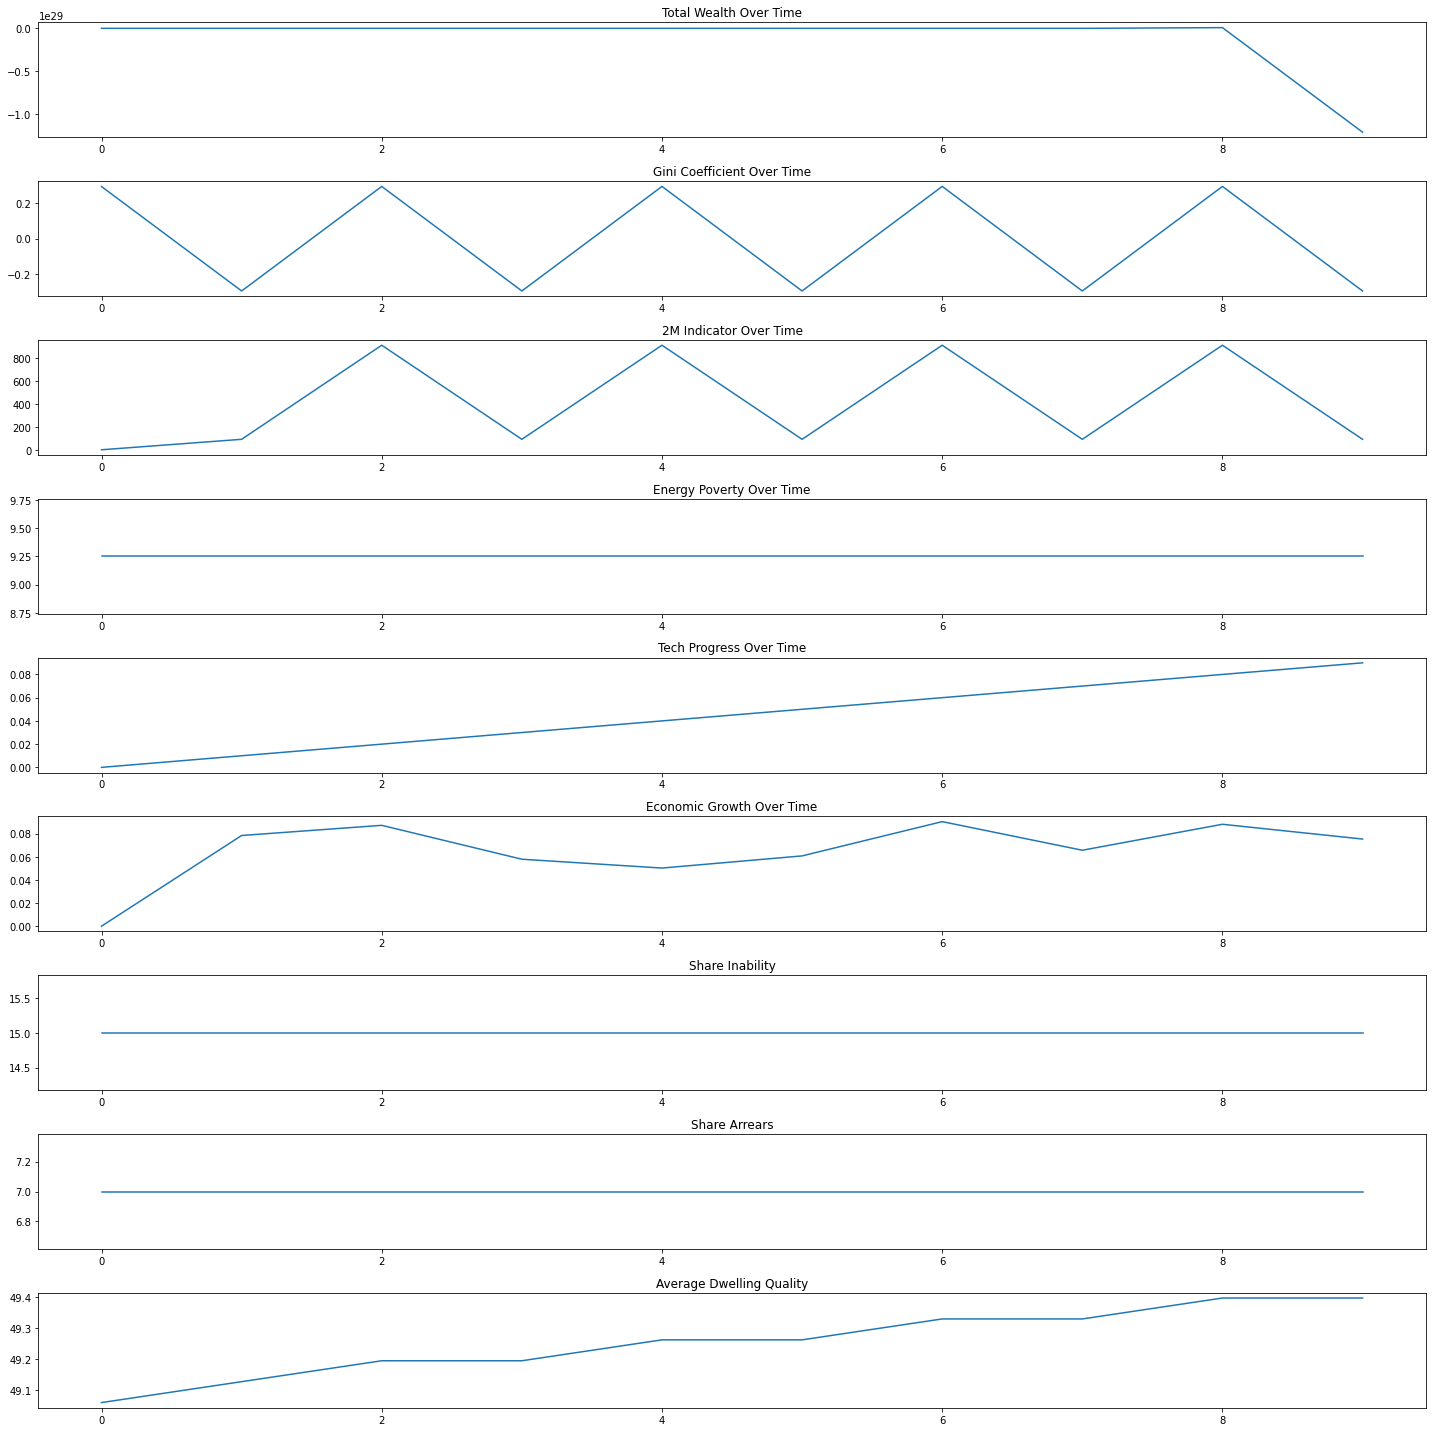

In [25]:
# Plot the data
fig, axs = plt.subplots(9, 1, figsize=(20, 20))

axs[0].plot(model_df["Total Wealth"])
axs[0].set_title("Total Wealth Over Time")

axs[1].plot(model_df["Gini"])
axs[1].set_title("Gini Coefficient Over Time")

axs[2].plot(model_df["2M indicator"])
axs[2].set_title("2M Indicator Over Time")

axs[3].plot(model_df["Energy Poverty"])
axs[3].set_title("Energy Poverty Over Time")

axs[4].plot(model_df["Tech Progress"])
axs[4].set_title("Tech Progress Over Time")

axs[5].plot(model_df["Growth"])
axs[5].set_title("Economic Growth Over Time")

axs[6].plot(model_df["Share Inability"])
axs[6].set_title("Share Inability")

axs[7].plot(model_df["Share Arrears"])
axs[7].set_title("Share Arrears")

axs[8].plot(model_df["Average Dwelling Quality"])
axs[8].set_title("Average Dwelling Quality")

# Adjust spacing and display the plot
plt.tight_layout()
plt.show()